# Project: Identify Customer Segments

In this project, I apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that I use has been provided by Bertelsmann Arvato Analytics, and represents a real-life data science task.



In [1]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline



'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. I use this information to cluster the general population into groups with similar demographic properties. Then, I will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.


In [2]:
# Loading in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep = ';')

# Loading in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')

In [35]:
azdias.head(10)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3,1,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,-1,2,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,-1,1,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,-1,3,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,-1,3,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


In [36]:
# Checking the structure of the data after it's loaded
columns = azdias.columns
print('The columns of the demographic dataset:\n',columns)
print('The number of features ',azdias.shape[1])
print('The number of samples ',azdias.shape[0])



The columns of the demographic dataset:
 Index(['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GEBURTSJAHR', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN',
       'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE',
       'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT',
       'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT',
       'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP',
       'ALTER_HH', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE',
       'KK_KUNDENTYP', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', '

In [5]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [6]:
feat_info[feat_info['type']=='categorical']

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
17,LP_FAMILIE_FEIN,person,categorical,[0]
18,LP_FAMILIE_GROB,person,categorical,[0]
19,LP_STATUS_FEIN,person,categorical,[0]
20,LP_STATUS_GROB,person,categorical,[0]


## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. I use this file to help to make cleaning decisions during this stage of the project. First of all, I assess the demographics data in terms of missing data. 

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object, so  I'll need to do a little bit of parsing to make use of it to identify and clean the data. 

In [3]:
for row in range(len(feat_info)):
    m_o_u = feat_info.iloc[row]['missing_or_unknown']
    m_o_u = m_o_u.strip("[").strip("]").split(sep = ",")
    
    m_o_u = [int(self) if (self!= "" and self!="X" and self!="XX") else self for self in m_o_u]
    
    if m_o_u !=[""]:
        azdias = azdias.replace({feat_info.iloc[row]['attribute']:m_o_u}, np.nan)
    


In [4]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [18]:
azdias.to_csv('azdias_nan.csv', sep = ";")

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. I use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. I will identify and document these columns. 

In [5]:
azdias_nan = pd.read_csv('azdias_nan.csv', sep = ';')
azdias_nan.head(10)

,Unnamed: 0,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,0,NaN,2.0,1,2.0,3,4,3,5,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,1.0,2,5.0,1,5,2,5,4,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,2,NaN,3.0,2,3.0,1,4,1,2,3,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,3,2.0,4.0,2,2.0,4,2,5,2,1,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,4,NaN,3.0,1,5.0,4,3,4,1,3,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,5,3.0,1.0,2,2.0,3,1,5,2,2,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,6,NaN,2.0,2,5.0,1,5,1,5,4,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,7,NaN,1.0,1,3.0,3,3,4,1,3,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,8,NaN,3.0,1,3.0,4,4,2,4,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,9,NaN,3.0,2,4.0,2,4,2,3,5,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


In [6]:
azdias_nan.drop(['Unnamed: 0'], axis = 1, inplace = True)

azdias_nan.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [20]:
# Performing an assessment of how much missing data there is in each column of the dataset.
azdias_nan_col = azdias.columns

num_nans = {}
for column in azdias_nan_col:
    num_nan = azdias[column].isna().sum()
    num_nans[column] = num_nan
    
num_nans


{'AGER_TYP': 685843,
 'ALTERSKATEGORIE_GROB': 2881,
 'ANREDE_KZ': 0,
 'CJT_GESAMTTYP': 4854,
 'FINANZ_MINIMALIST': 0,
 'FINANZ_SPARER': 0,
 'FINANZ_VORSORGER': 0,
 'FINANZ_ANLEGER': 0,
 'FINANZ_UNAUFFAELLIGER': 0,
 'FINANZ_HAUSBAUER': 0,
 'FINANZTYP': 0,
 'GEBURTSJAHR': 392318,
 'GFK_URLAUBERTYP': 4854,
 'GREEN_AVANTGARDE': 0,
 'HEALTH_TYP': 111196,
 'LP_LEBENSPHASE_FEIN': 97632,
 'LP_LEBENSPHASE_GROB': 94572,
 'LP_FAMILIE_FEIN': 77792,
 'LP_FAMILIE_GROB': 77792,
 'LP_STATUS_FEIN': 4854,
 'LP_STATUS_GROB': 4854,
 'NATIONALITAET_KZ': 108315,
 'PRAEGENDE_JUGENDJAHRE': 108164,
 'RETOURTYP_BK_S': 4854,
 'SEMIO_SOZ': 0,
 'SEMIO_FAM': 0,
 'SEMIO_REL': 0,
 'SEMIO_MAT': 0,
 'SEMIO_VERT': 0,
 'SEMIO_LUST': 0,
 'SEMIO_ERL': 0,
 'SEMIO_KULT': 0,
 'SEMIO_RAT': 0,
 'SEMIO_KRIT': 0,
 'SEMIO_DOM': 0,
 'SEMIO_KAEM': 0,
 'SEMIO_PFLICHT': 0,
 'SEMIO_TRADV': 0,
 'SHOPPER_TYP': 111196,
 'SOHO_KZ': 73499,
 'TITEL_KZ': 889061,
 'VERS_TYP': 111196,
 'ZABEOTYP': 0,
 'ALTER_HH': 310267,
 'ANZ_PERSONEN': 73499,

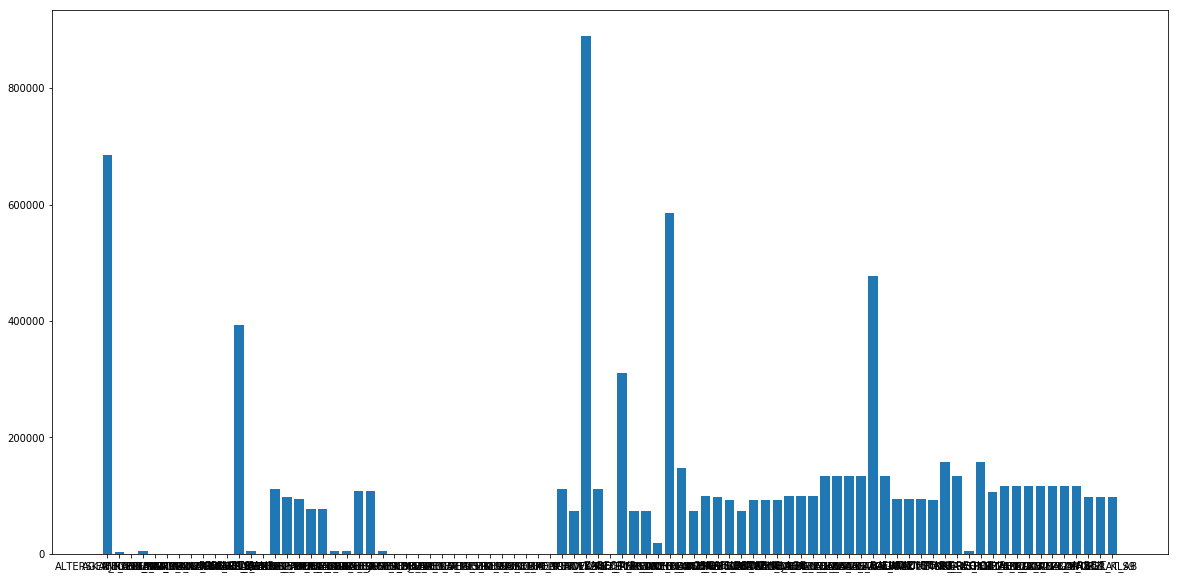

In [21]:
# Investigating patterns in the amount of missing data in each column.
plt.figure(figsize= (20,10))
plt.bar(num_nans.keys(), num_nans.values())
plt.show()



In [23]:
outliers = []
for key, value in num_nans.items():
    if value>0.2*azdias_nan.shape[0]:
        outliers.append(key)
outliers

['AGER_TYP',
 'GEBURTSJAHR',
 'TITEL_KZ',
 'ALTER_HH',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX']

In [7]:
# Removing the outlier columns from the dataset.

azdias_nan.drop(['AGER_TYP', 'GEBURTSJAHR', 'KK_KUNDENTYP', 'TITEL_KZ', 'ALTER_HH', 'KBA05_BAUMAX'], axis = 1, inplace = True)
azdias_nan.shape

(891221, 79)

#### Step 1.1.3: Assess Missing Data in Each Row

Now, I perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, I should see some groups of points that have a very different numbers of missing values. I divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, I should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. I will select at least five of these columns and compare the distribution of values.


In [8]:
# How much data is missing in each row of the dataset?
from time import time
start = time()
num_nans_row = []

for index in range(azdias_nan.shape[0]):
    num_nan_row = azdias_nan.loc[index].isna().sum()
    num_nans_row.append(num_nan_row)

end = time()
num_nans_row = np.array(num_nans_row)
min_ = np.min(num_nans_row)
max_ = np.max(num_nans_row)
mean_ = np.mean(num_nans_row)

print('The process lasted ', end-start, 'seconds')

print('The list of rows with NaNs is ', num_nans_row.size, 'long')

print('The minimum value in the list is ',min_, ' the maximum value is ',  max_, ' and the mean of the values is ', mean_)



The process lasted  1181.3779227733612 seconds
The list of rows with NaNs is  891221 long
The minimum value in the list is  0  the maximum value is  49  and the mean of the values is  5.649893797385833


In [28]:
# determining the number of rows with certain amount of missing data
a = []
b = list(range(50))
for i in range(50):
    big = np.argwhere(num_nans_row>i)
    a.append(big.size)



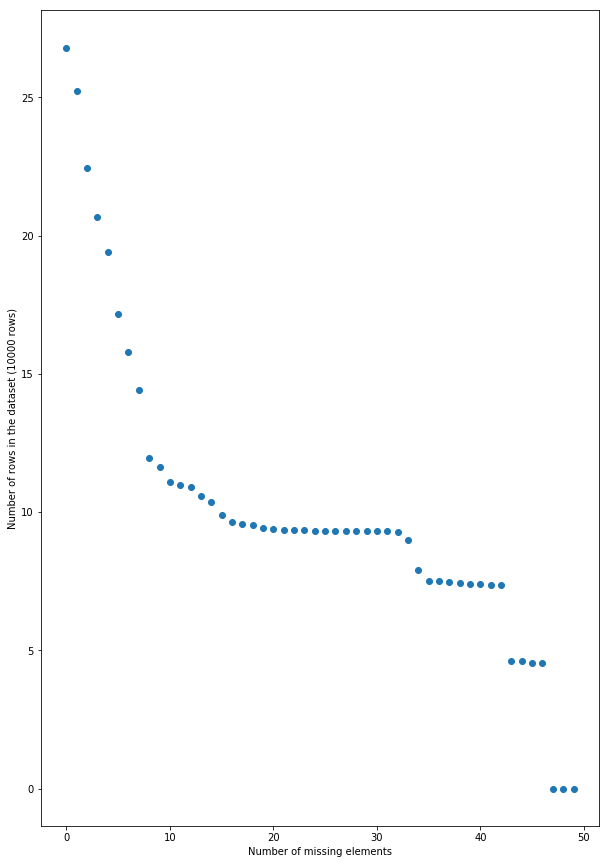

In [29]:
# plotting a graph: number of rows in dataset vs number of missing data

a = np.array(a)
c = a/10000
plt.figure(figsize = (10,15))   
plt.scatter(b,c )
plt.xlabel('Number of missing elements')
plt.ylabel('Number of rows in the dataset (10000 rows)')
plt.show()

In [9]:
#determining the indices of rows where the number of missing data is more or less than 20
less = np.argwhere(num_nans_row<21 )[:,0]
more = np.argwhere(num_nans_row>20)[:,0]

more[0:10]

array([ 0, 11, 14, 17, 24, 30, 35, 46, 48, 53], dtype=int64)

In [31]:
# Writing code to divide the data into two subsets based on the number of missing values in each row.

azdias.drop(index = (more[i] for i in range(more.size)), inplace = True)

azdias.shape


(797426, 79)

In [32]:
azdias.to_csv('demo_less.csv', sep = ';')

In [43]:
azdias_nan = pd.read_csv('azdias_nan.csv', sep = ';')
azdias_nan.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [10]:
azdias_nan.drop(index = (less[i] for i in range(less.size)), inplace = True)

azdias_nan.shape


(93795, 79)

In [14]:
azdias_nan.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,2.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,3.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,2.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,3.0,2,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
azdias_nan.to_csv('demo_more.csv', sep = ';')

In [37]:
demo_less = pd.read_csv('demo_less.csv', sep = ';')
demo_less.shape

(797426, 80)

In [16]:
demo_less.drop(['Unnamed: 0'], axis = 1, inplace = True)
demo_more.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3.0,2,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
# Comparing the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
test_features = ['FINANZ_MINIMALIST','FINANZ_VORSORGER','FINANZ_ANLEGER',
                 'FINANZ_HAUSBAUER','FINANZTYP','LP_FAMILIE_FEIN','LP_STATUS_FEIN','LP_STATUS_GROB', 'KBA05_ANTG1','KBA05_ANTG2',
                 'KBA05_ANTG3','KBA05_ANTG4']
feat_distr_less ={} 
for feature in test_features:
    nan = demo_less[feature].isna().sum()
    feat_distr_less[feature] = nan
    
feat_distr_less

{'FINANZ_MINIMALIST': 0,
 'FINANZ_VORSORGER': 0,
 'FINANZ_ANLEGER': 0,
 'FINANZ_HAUSBAUER': 0,
 'FINANZTYP': 0,
 'LP_FAMILIE_FEIN': 31121,
 'LP_STATUS_FEIN': 4634,
 'LP_STATUS_GROB': 4634,
 'KBA05_ANTG1': 39536,
 'KBA05_ANTG2': 39536,
 'KBA05_ANTG3': 39536,
 'KBA05_ANTG4': 39536}

In [17]:
demo_more = pd.read_csv('demo_more.csv', sep = ',')


In [16]:
test_features = ['FINANZ_MINIMALIST','FINANZ_VORSORGER','FINANZ_ANLEGER',
                 'FINANZ_HAUSBAUER','FINANZTYP','LP_FAMILIE_FEIN','LP_STATUS_FEIN','LP_STATUS_GROB', 'KBA05_ANTG1','KBA05_ANTG2',
                 'KBA05_ANTG3','KBA05_ANTG4']
feat_distr_more ={} 
for feature in test_features:
    nan = demo_more[feature].isna().sum()
    feat_distr_more[feature] = nan
    
feat_distr_more

{'FINANZ_MINIMALIST': 0,
 'FINANZ_VORSORGER': 0,
 'FINANZ_ANLEGER': 0,
 'FINANZ_HAUSBAUER': 0,
 'FINANZTYP': 0,
 'LP_FAMILIE_FEIN': 46671,
 'LP_STATUS_FEIN': 220,
 'LP_STATUS_GROB': 220,
 'KBA05_ANTG1': 93788,
 'KBA05_ANTG2': 93788,
 'KBA05_ANTG3': 93788,
 'KBA05_ANTG4': 93788}

#### Discussion 1.1.3: Assess Missing Data in Each Row

I plotted the graph: number of people with certain amount of missing data vs missing data per row . Observing the graph we can learn that most of the people provided all the data they were asked about. It also turns out that after 20 there is no significant decrese in the number of people with missing data (not considering the last few points of the graph), so I chose 20 as a treshold when splitting the dataset into 2 parts, because if a person has at least 20 missing data, it is very likely that the same person has e.g. at least 30 missing data too.
For test features, I choose features from 3 different kinds: some with 0 missing data, some with a few thousend missing data and some with about 100 000 missing data. Checking the distribution of the missing data I can say that the number of missing data in the first 2 categories is proportional to the size of the dataset, so there is no significant difference between the 2 subsets. However, the rows with large number of missing data are located in the subset with more missing data, so using the other subset we can reduce the effect of the rows with larger number of missing values.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which one can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, I need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. I need to check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, I make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, |I will keep without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, I perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether I will keep, drop, or re-encode each. Then, in the last part, I will create a new data frame with only the selected and engineered columns.



In [10]:
# How many features are there of each data type?
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')
feat_info.head()


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [11]:
types = feat_info['type'].value_counts()
types

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, I would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, I perform one of the following:
- For binary (two-level) categoricals that take numeric values, I can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, I need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), I can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis.

In [17]:
# Assessing categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

feat_cat = feat_info[feat_info['type']=='categorical']
feat_cat_list = feat_cat['attribute']
feat_cat_list = list(feat_cat_list.drop(labels = [0,47]))
feat_cat_list


df_less[feat_cat_list].head(10)

,ANREDE_KZ,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,GEBAEUDETYP,OST_WEST_KZ,CAMEO_DEUG_2015,CAMEO_DEU_2015
0,2,5.0,1,10.0,0,5.0,3.0,2.0,1.0,1.0,3.0,1.0,NaN,2.0,5,8.0,W,8.0,8A
1,2,3.0,1,10.0,1,1.0,1.0,3.0,2.0,1.0,2.0,0.0,NaN,1.0,5,1.0,W,4.0,4C
2,2,2.0,6,1.0,0,0.0,NaN,9.0,4.0,1.0,1.0,0.0,NaN,1.0,3,1.0,W,2.0,2A
3,1,5.0,5,5.0,0,10.0,5.0,3.0,2.0,1.0,2.0,0.0,NaN,2.0,4,1.0,W,6.0,6B
4,2,2.0,2,1.0,0,1.0,1.0,4.0,2.0,1.0,0.0,0.0,NaN,2.0,4,1.0,W,8.0,8C
5,2,5.0,4,12.0,0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,NaN,1.0,4,1.0,W,4.0,4A
6,1,3.0,5,9.0,0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,NaN,1.0,1,8.0,W,2.0,2D
7,1,3.0,6,3.0,1,1.0,1.0,10.0,5.0,1.0,3.0,0.0,NaN,2.0,6,3.0,W,1.0,1A
8,2,4.0,1,12.0,1,1.0,1.0,3.0,2.0,1.0,3.0,0.0,NaN,2.0,4,3.0,W,1.0,1E
9,2,1.0,6,8.0,0,1.0,1.0,1.0,1.0,1.0,2.0,0.0,NaN,2.0,3,1.0,W,9.0,9D


In [17]:
# binary: ['ANDERE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ', ] # OST_WEST with letters
# worth to keep and one-hot encoding:
# ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBTYP', 'LP_FAMILIE_GROB', 'SHOPPER_TYP','LP_STATUS_GROB', ' ZABEOTYP', 'CAMEO_DEUG_2015'  ]

# to drop: ['LP_FAMILIE_FEIN' 'LP_STATUS_FEIN', ' NATIONALITAET_KZ',  'TITEL_KZ' , 'GEBAEUDETYP', 'CAMEO_DEU_2015' ]

demo_less.drop(['LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'NATIONALITAET_KZ', 'GEBAEUDETYP', 'CAMEO_DEU_2015' ], axis = 1, inplace = True)
demo_less.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP',
       'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_GROB',
       'LP_STATUS_GROB', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S',
       'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT',
       'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT',
       'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'ALTER_HH',
       'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH',
       'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_DEUG_2015',
       'CAMEO_INTL_2015', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3',
       'K

In [18]:
# Re-encoding categorical variable(s) to be kept in the analysis.
demo_less = pd.get_dummies(demo_less, columns = ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_GROB', 'SHOPPER_TYP','LP_STATUS_GROB', 'ZABEOTYP', 'CAMEO_DEUG_2015'] )
demo_less.shape

(797545, 122)

In [19]:
#replacing values represented by letters with numbers
demo_less.replace({'OST_WEST_KZ': {'O': 0, 'W':1}}, inplace = True)
demo_less['OST_WEST_KZ'][0:10]

0    1
1    1
2    1
3    1
4    1
5    1
6    1
7    1
8    1
9    1
Name: OST_WEST_KZ, dtype: int64

#### Discussion 1.2.1: Re-Encode Categorical Features

I kept the categorical features with binary values. I replaced O-W categories in OST_WEST KZ with 0-1 to be able to process the  data.

I investigated the features with multi-level categories and dropped the followings:
'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN' and 'CAMEO_DEU_2015' because 'LP_FAMILIE_GROB', 'LP_STATUS_GROB' and 'CAMEO_DEUG_2015 containe the similar information (in a lower quality) but are made of less categories, that makes the analysis easier without any relevant information-loss. 

I also dropped 'NATIONALITAET_KZ' and 'GEBAEUDETYP' because I don't think it would be a relevant information.
'TITEL_KZ' because lot of information is missing in this feature.



#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention.
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, I will create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. I break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).


In [25]:
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')
feat_info[feat_info['type']=='mixed']

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1,0]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [21]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new features.
DECADES = []
for element in demo_less['PRAEGENDE_JUGENDJAHRE']:
    if (element in [range(1,2)]):
        DECADES.append(1)
    elif (element in [3,4]):
        DECADES.append(2)
    elif (element in [5,6,7]):
        DECADES.append(3)
    elif (element in [8,9]):
        DECADES.append(4)
    elif (element in [10,11,12,13]):
        DECADES.append(5)
    else:
        DECADES.append(6)
        
DECADES[0:20]


[6, 6, 4, 4, 2, 5, 4, 5, 6, 2, 4, 6, 3, 6, 5, 4, 5, 5, 6, 4]

In [22]:
MOVEMENT = []
for element in demo_less['PRAEGENDE_JUGENDJAHRE']:
    if (element in [1,3,5,8,10,12,14]):
        MOVEMENT.append(1)
        
    else:
        MOVEMENT.append(2)
        
MOVEMENT[0:20]

[1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 2]

In [23]:
#Adding the 2 new features to the data frame ad drop the original columns
demo_less['DECADES'] = DECADES
demo_less['MOVEMENT'] = MOVEMENT
demo_less.drop(['PRAEGENDE_JUGENDJAHRE'], axis = 1, inplace = True)
demo_less.shape

(797545, 123)

In [24]:
#encoding the 2 new features
demo_less = pd.get_dummies( demo_less, columns = ['DECADES', 'MOVEMENT'] )
demo_less.shape

(797545, 128)

In [25]:
# The same with the other mix-typed feautre
wealth = []
for element in demo_less['CAMEO_INTL_2015']:
    if (element in [11,12, 13, 14, 15]):
        wealth.append(1)
    elif (element in [21,22,23,24, 25]):
        wealth.append(2)
    elif (element in [31, 32, 33, 34, 35]):
        wealth.append(3)
    elif (element in [41, 42, 43, 44, 45]):
        wealth.append(4)
    else:
        wealth.append(5)
        
print(wealth[0:20])
print(len(wealth))

[5, 2, 1, 4, 5, 2, 1, 1, 1, 5, 4, 3, 4, 4, 2, 3, 2, 5, 5, 4]
797545


In [26]:
family = []
for element in demo_less['CAMEO_INTL_2015']:
    if (element in [11, 21, 31, 41, 51]):
        family.append(1)
    elif (element in [12, 22, 32, 42, 52]):
        family.append(2)
    elif (element in [13, 23, 33, 43, 53]):
        family.append(3)
    elif (element in [14, 24, 34, 44, 54]):
        family.append(4)
    else:
        family.append(5)
        
print(family[0:20])
print(len(family))

[1, 4, 2, 3, 4, 2, 4, 3, 5, 1, 3, 3, 1, 1, 4, 4, 4, 5, 1, 3]
797545


In [28]:
demo_less['WEALTH'] = wealth
demo_less['FAMILY'] = family
demo_less.drop(['CAMEO_INTL_2015'], axis = 1, inplace = True)
demo_less.shape



(797545, 129)

In [29]:
demo_less = pd.get_dummies( demo_less, columns = ['WEALTH', 'FAMILY'] )
demo_less.shape

(797545, 137)

In [30]:
demo_less.drop(['LP_LEBENSPHASE_FEIN'], axis = 1, inplace = True)
demo_less.shape

(797545, 136)

In [31]:
#re-encoding some more features
demo_less = pd.get_dummies(demo_less, columns = ['LP_LEBENSPHASE_GROB','WOHNLAGE','PLZ8_BAUMAX'])
demo_less.shape

(797545, 164)

In [32]:
demo_less.to_csv('demo_less1.csv', sep = ';')

#### Discussion 1.2.2: Engineer Mixed-Type Features

For 'PRAEGENDE_JUGENDJAHRE', I created two new features ('DECADE' and 'MOVEMENT') and sorted its elements into the 2 new features. I made one-hot encoding on the 2 new features and dropped the original feature. I did the same with 'CAMEO_INTL_2015', the 2 new variables are called 'WEALTH' and 'FAMILY'. 

I think, LP_LEBENSPHASE_FEIN can be dropped because LP_LEBENSPHASE_GROB containes the same information in a lower quality, so there is no significant information-loss when dropped. I feel the categories of LP_LEBENSPHASE_GROB  to be distinct so it can be kept and a one-hot-encoding can be applied.

I am of the same opinion in association with the features 'WOHNLAGE', 'KBA05_BAUMAX' and 'PLZ08_BAUMAX', so I kept them and apllied one-hot encoding.


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, I need to make sure that my data frame now only has the columns that I want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.



### Step 1.3: Create a Cleaning Function

Even though I've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that I'll need to perform the same cleaning steps on the customer demographics data. In this substep, I complete the function below to execute the main feature selection, encoding, and re-engineering steps I performed above. Then, when it comes to looking at the customer data in Step 3, I can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [16]:
demo = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep = ';')
features = demo.columns.tolist()

In [2]:
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep = ';')
features_c = customers.columns.tolist()

#### Check if the features of the 2 subsets are the same

In [19]:
len(features) == len(features_c)


True

In [22]:
check_dict = {}
for feature, feature_c in zip(features, features_c):
    if feature == feature_c:
        check_dict[feature] = 1
        
    else:
        check_dict[feature] = 0
        
0 in check_dict.values()

False

#### The cleaning function

In [25]:

def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
       
    #creating a list of attributes and comparing to the Feature Summary
    for row in range(len(feat_info)):
    m_o_u = feat_info.iloc[row]['missing_or_unknown']
    m_o_u = m_o_u.strip("[").strip("]").split(sep = ",")
    
    m_o_u = [int(self) if (self!= "" and self!="X" and self!="XX") else self for self in m_o_u]
    
    if m_o_u !=[""]:
        df = df.replace({feat_info.iloc[row]['attribute']:m_o_u}, np.nan)
    
    
    
    # removing selected columns and rows, ...
    #dropping the columns with too much missing values
    cols_to_drop = ['AGER_TYP', 'GEBURTSJAHR', 'KK_KUNDENTYP','LP_FAMILIE_FEIN',
                    'LP_STATUS_FEIN', 'NATIONALITAET_KZ' , 'ALTER_HH','GEBAEUDETYP', 'CAMEO_DEU_2015',
                    'LP_LEBENSPHASE_FEIN', 'KB05_BAUMAX']
    for col in cols_to_drop:
        df.drop(col, axis = 1, inplace = True)
    
    #dropping rows with too much missing values
    num_nans_row = []
    for index in range(df.shape[0]):
        num_nan_row = df.loc[index].isna().sum()
        num_nans_row.append(num_nan_row)
        
    num_nans_row = np.array(num_nans_row) 
    
    rows_to_drop = np.argwhere(num_nans_row > 20)[:,0]
    
    
    df.drop(index = (rows_to_drop[i] for i in range(rows_to_drop.size)), inplace = True)
    
    
    # selecting, re-encoding, and engineering column values.
    # decoding columns with mixed data types, creating new features
    DECADES = []
    for element in df['PRAEGENDE_JUGENDJAHRE']:
        if (element in [range(1,2)]):
            DECADES.append(1)
        elif (element in [3,4]):
            DECADES.append(2)
        elif (element in [5,6,7]):
            DECADES.append(3)
        elif (element in [8,9]):
            DECADES.append(4)
        elif (element in [10,11,12,13]):
            DECADES.append(5)
        else:
            DECADES.append(6)
        
    MOVEMENT = []
    for element in df['PRAEGENDE_JUGENDJAHRE']:
        if (element in [1,3,5,8,10,12,14]):
            MOVEMENT.append(1)
        
        else:
            MOVEMENT.append(2)
            
    df['DECADES'] = DECADES
    df['MOVEMENT'] = MOVEMENT
    df.drop(['PRAEGENDE_JUGENDJAHRE'], axis = 1, inplace = True)
    df = pd.get_dummies( df, columns = ['DECADES', 'MOVEMENT'] )       
    
    wealth = []
    for element in df['CAMEO_INTL_2015']:
        if (element in [11,12, 13, 14, 15]):
            wealth.append(1)
        elif (element in [21,22,23,24, 25]):
            wealth.append(2)
        elif (element in [31, 32, 33, 34, 35]):
            wealth.append(3)
        elif (element in [41, 42, 43, 44, 45]):
            wealth.append(4)
        else:
            wealth.append(5)
    
    family = []
    for element in df['CAMEO_INTL_2015']:
        if (element in [11, 21, 31, 41, 51]):
            family.append(1)
        elif (element in [12, 22, 32, 42, 52]):
            family.append(2)
        elif (element in [13, 23, 33, 43, 53]):
            family.append(3)
        elif (element in [14, 24, 34, 44, 54]):
            family.append(4)
        else:
            family.append(5)
            
    df['WEALTH'] = wealth
    df['FAMILY'] = family
    df.drop(['CAMEO_INTL_2015'], axis = 1, inplace = True)
    
    #re-encoding values
    df = pd.get_dummies( df, columns = ['WEALTH', 'FAMILY'] )       
    
    df = pd.get_dummies(df, columns = ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_GROB', 'SHOPPER_TYP','LP_STATUS_GROB', 'ZABEOTYP', 'CAMEO_DEUG_2015'] )
    df.replace({'OST_WEST_KZ': {'O': 0, 'W':1}}, inplace = True)
    df = pd.get_dummies(df, columns = ['LP_LEBENSPHASE_GROB','WOHNLAGE','PLZ8_BAUMAX'])
    
    # Returning the cleaned dataframe.
    
    return df

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before I apply dimensionality reduction techniques to the data, I need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. 


In [3]:
demo_less = pd.read_csv('demo_less1.csv', sep = ';')
demo_less.head()

,Unnamed: 0,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,...,KBA05_BAUMAX_1.0,KBA05_BAUMAX_2.0,KBA05_BAUMAX_3.0,KBA05_BAUMAX_4.0,KBA05_BAUMAX_5.0,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0
0,0,1.0,2,1,5,2,5,4,5,0,...,0,0,0,0,1,1,0,0,0,0
1,1,3.0,2,1,4,1,2,3,5,1,...,0,0,0,0,0,1,0,0,0,0
2,2,4.0,2,4,2,5,2,1,2,0,...,1,0,0,0,0,1,0,0,0,0
3,3,3.0,1,4,3,4,1,3,2,0,...,0,0,0,0,0,0,1,0,0,0
4,4,1.0,2,3,1,5,2,2,5,0,...,0,0,0,0,0,1,0,0,0,0


In [4]:
demo_less.drop('Unnamed: 0', axis = 1, inplace = True)
demo_less.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,KBA05_BAUMAX_1.0,KBA05_BAUMAX_2.0,KBA05_BAUMAX_3.0,KBA05_BAUMAX_4.0,KBA05_BAUMAX_5.0,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0
0,1.0,2,1,5,2,5,4,5,0,3.0,...,0,0,0,0,1,1,0,0,0,0
1,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,0,0,0,1,0,0,0,0
2,4.0,2,4,2,5,2,1,2,0,2.0,...,1,0,0,0,0,1,0,0,0,0
3,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,0,0,0,1,0,0,0
4,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0,0,0,0,1,0,0,0,0


In [5]:

for feature in demo_less.columns:
    demo_less[feature] = demo_less[feature].replace(np.nan, 0)


In [7]:
# Applying feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
demo_less_scaled = scaler.fit_transform(demo_less)

demo_less_scaled[0:10]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


array([[-1.7336873 ,  0.95806099, -1.4946277 , ..., -0.26063639,
        -0.27660618, -0.3728338 ],
       [ 0.20809088,  0.95806099, -1.4946277 , ..., -0.26063639,
        -0.27660618, -0.3728338 ],
       [ 1.17897997,  0.95806099,  0.68311966, ..., -0.26063639,
        -0.27660618, -0.3728338 ],
       ...,
       [ 0.20809088, -1.04377489,  0.68311966, ..., -0.26063639,
        -0.27660618, -0.3728338 ],
       [ 0.20809088,  0.95806099, -0.76871191, ..., -0.26063639,
        -0.27660618, -0.3728338 ],
       [ 0.20809088,  0.95806099, -0.76871191, ..., -0.26063639,
        -0.27660618, -0.3728338 ]])

### Discussion 2.1: Apply Feature Scaling

I didn't want to delete all the data points containing missing values because we would have lost a lot of points, so a significant amount of information. I replaced np.nan objects with 0 and standrad scaling on the modified dataset.

### Step 2.2: Perform Dimensionality Reduction

On my scaled data, I am now ready to apply dimensionality reduction techniques.

- I use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. 
- I check out the ratio of variance explained by each principal component as well as the cumulative variance explained. I try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what I find, I will select a value for the number of transformed features I'll retain for the clustering part of the project.
- Once I've made a choice for the number of components to keep, I will make sure I re-fit a PCA instance to perform the decided-on transformation.

In [8]:
# Applying PCA to the data.
from sklearn.decomposition import PCA
def do_pca_and_variance(n_components, data):
    pca = PCA(n_components)
    X_pca = pca.fit_transform(data)
    var = pca.explained_variance_ratio_
    return var




In [9]:
# Investigating the variance accounted for by each principal component.
variance = {}
for component in range(50, 10, -5):
    pca = PCA(component)
    X_pca = pca.fit_transform(demo_less_scaled)
    var = pca.explained_variance_ratio_.sum()
    variance[component] = var

variance


{50: 0.7003093934309431,
 45: 0.6667973392119996,
 40: 0.6321537385952146,
 35: 0.59611033880449,
 30: 0.5568058382389992,
 25: 0.5145737924341841,
 20: 0.46565001883438273,
 15: 0.41041468090873917}

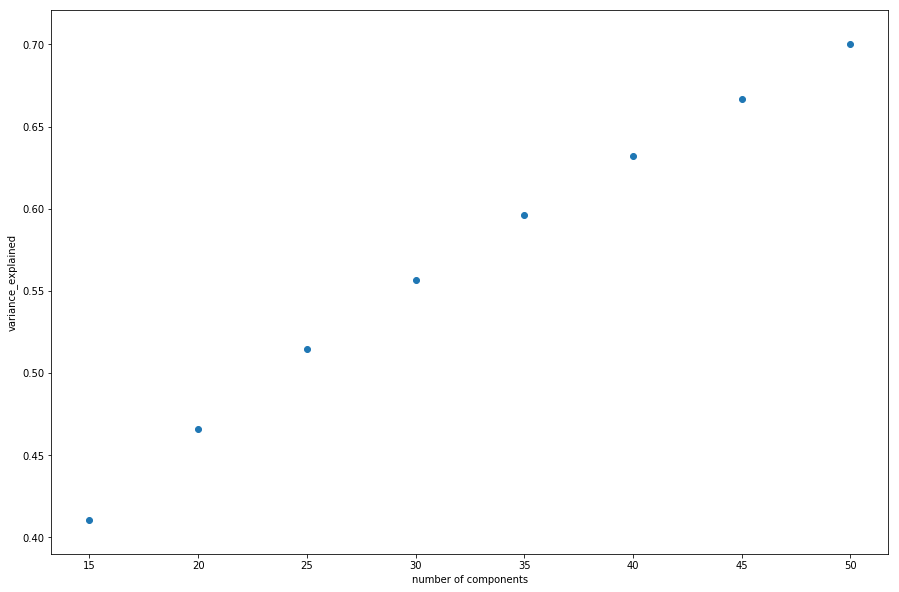

In [10]:
plt.figure(figsize = (15,10))
plt.scatter(variance.keys(), variance.values())
plt.xlabel('number of components')
plt.ylabel('variance_explained')
plt.show()

In [11]:
# Re-applying PCA to the data while selecting for number of components to retain.
do_pca_and_variance(50, demo_less_scaled)



array([0.0903561 , 0.06837933, 0.04117437, 0.03128064, 0.02345503,
       0.02151042, 0.01823707, 0.01754868, 0.01620068, 0.015463  ,
       0.01439094, 0.01406375, 0.01322918, 0.01266839, 0.01254753,
       0.01206635, 0.0118528 , 0.01116897, 0.01091029, 0.01081804,
       0.01026189, 0.0101751 , 0.00978067, 0.00946271, 0.00937685,
       0.00899521, 0.00869253, 0.00863582, 0.0083718 , 0.00826807,
       0.00817799, 0.00799284, 0.00767274, 0.0076248 , 0.00752882,
       0.00750726, 0.00738791, 0.00720006, 0.00710723, 0.00705453,
       0.00693438, 0.00685145, 0.00680433, 0.00675232, 0.00668285,
       0.00664999, 0.00655733, 0.00648402, 0.00645451, 0.00638269])

### Discussion 2.2: Perform Dimensionality Reduction

I set the original number of components to be 50 and investigated how the ratio of explained variance varies when decreasing the number of components. Because the original dataset contained lots of missing data, I decided to set the limit of ratio to 70%, so the amount of lost information would not be too big and the number of features could be about the third of the original number of features so we will need less computational capacity when we can spare working time, too.


### Step 2.3: Interpret Principal Components

Now that I have my transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

Each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, I will map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. I will use the data dictionary document to help in understanding these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.


In [14]:
from sklearn.decomposition import PCA
pca = PCA(50)
X_pca = pca.fit_transform(demo_less_scaled)
pca_components = pca.components_
pca_components

array([[-9.09486866e-02,  1.52504625e-02, -1.95066320e-01, ...,
         6.37905392e-02,  8.36043276e-02,  1.15846710e-01],
       [ 2.25105685e-01,  4.37969653e-02,  8.05778204e-02, ...,
         2.79786074e-02,  3.22376330e-02,  3.96265357e-02],
       [ 2.23925891e-02, -3.47900630e-01,  1.33552689e-01, ...,
         1.14680521e-02,  1.78280720e-02,  4.48170053e-02],
       ...,
       [ 8.47847026e-03,  2.03920036e-02,  5.41234256e-04, ...,
        -2.13757456e-02,  6.81065438e-02, -3.98609276e-02],
       [ 3.25669914e-03, -1.24058979e-02,  2.21972602e-02, ...,
         6.51071639e-02, -4.03446175e-03, -2.83204301e-03],
       [-2.84837112e-02,  1.94698761e-02, -1.18752776e-04, ...,
         2.57552627e-01, -1.70834737e-01,  1.96518534e-02]])

In [15]:
pca.components_.shape

(50, 164)

In [16]:
# Mapping weights for the first principal component to corresponding feature names
# and then printing the linked values, sorted by weight.

def principal_comp_to_features(pca_components, number):
    comp = {}
    comp_sorted = {}
    for component, feature in zip(pca_components[number], demo_less.columns):
        comp[feature] = component
    
    
    
    values_sorted =sorted(comp.values(), reverse = True)
    
    for value in values_sorted:
        for key in comp.keys():
            if comp[key] == value:
                comp_sorted[key] = value
                
    return comp_sorted
    




In [17]:
principal_comp_to_features(pca_components, 0)

{'LP_STATUS_GROB_1.0': 0.19456984566844676,
 'HH_EINKOMMEN_SCORE': 0.1833837499951483,
 'PLZ8_ANTG3': 0.18217434818814768,
 'PLZ8_ANTG4': 0.1803381827639138,
 'ORTSGR_KLS9': 0.1605693857587315,
 'EWDICHTE': 0.15964461550321044,
 'FINANZ_HAUSBAUER': 0.14777677836820516,
 'KBA05_ANTG4': 0.1294035798976399,
 'FINANZ_SPARER': 0.12112098782788458,
 'KBA05_ANTG3': 0.12001709253740293,
 'FINANZTYP_1': 0.1170028979645894,
 'ARBEIT': 0.11609264832548334,
 'PLZ8_BAUMAX_5.0': 0.11584670985847292,
 'PLZ8_ANTG2': 0.1158052684944836,
 'ANZ_HAUSHALTE_AKTIV': 0.11473720376646232,
 'LP_LEBENSPHASE_GROB_1.0': 0.11189164946409164,
 'CAMEO_DEUG_2015_9.0': 0.1096956150021464,
 'RELAT_AB': 0.10949119843657384,
 'KBA05_BAUMAX_5.0': 0.09605754530464819,
 'CAMEO_DEUG_2015_8.0': 0.09078404536776954,
 'MOVEMENT_1': 0.08855162307746778,
 'SEMIO_PFLICHT': 0.08795431768587614,
 'PLZ8_BAUMAX_4.0': 0.08360432763739374,
 'SEMIO_REL': 0.08339900152459659,
 'FAMILY_1': 0.08306555694401017,
 'ZABEOTYP_5': 0.0798738085544

In [18]:
# Mapping weights for the second principal component to corresponding feature names
# and then printing the linked values, sorted by weight.

principal_comp_to_features(pca_components,1)

{'ALTERSKATEGORIE_GROB': 0.22510568514405482,
 'FINANZ_VORSORGER': 0.21849719468538317,
 'ZABEOTYP_3': 0.20180638310698898,
 'SEMIO_ERL': 0.179751613731303,
 'SEMIO_LUST': 0.15792975806637338,
 'RETOURTYP_BK_S': 0.15233754971234004,
 'LP_LEBENSPHASE_GROB_2.0': 0.15169065084438269,
 'DECADES_3': 0.11640048160324859,
 'W_KEIT_KIND_HH': 0.10573751310214488,
 'CJT_GESAMTTYP_2.0': 0.10537318559875743,
 'DECADES_2': 0.10381747249899587,
 'FINANZTYP_5': 0.09595612747009473,
 'FINANZ_HAUSBAUER': 0.0914491382591329,
 'FINANZTYP_2': 0.08766592597662168,
 'FINANZ_MINIMALIST': 0.08057782039537117,
 'SEMIO_KRIT': 0.07681404689709677,
 'PLZ8_ANTG3': 0.07358981611031222,
 'FINANZTYP_6': 0.07069898297670144,
 'SHOPPER_TYP_3.0': 0.0706541854948908,
 'DECADES_4': 0.07036150683326677,
 'EWDICHTE': 0.06982030889408988,
 'PLZ8_ANTG4': 0.06974960290454102,
 'ORTSGR_KLS9': 0.06930166527722557,
 'CJT_GESAMTTYP_1.0': 0.06840644229870124,
 'SEMIO_KAEM': 0.0636224917681925,
 'GFK_URLAUBERTYP_4.0': 0.058164852080

In [19]:
# Mapping weights for the third principal component to corresponding feature names
# and then printing the linked values, sorted by weight.

principal_comp_to_features(pca_components, 2)

{'SEMIO_VERT': 0.32142280505524135,
 'SEMIO_FAM': 0.259369994696158,
 'SEMIO_SOZ': 0.2573571342599311,
 'SEMIO_KULT': 0.2506271262732091,
 'FINANZTYP_5': 0.13546325157883624,
 'FINANZ_MINIMALIST': 0.13355268852394098,
 'SHOPPER_TYP_0.0': 0.12431212636727386,
 'ZABEOTYP_1': 0.11566393773222003,
 'SEMIO_REL': 0.1088358466884469,
 'SEMIO_MAT': 0.08410413748696423,
 'RETOURTYP_BK_S': 0.07759845337845864,
 'GREEN_AVANTGARDE': 0.07239945257858248,
 'W_KEIT_KIND_HH': 0.06916361003878675,
 'ORTSGR_KLS9': 0.0644588197966962,
 'EWDICHTE': 0.06302730514641595,
 'MOVEMENT_2': 0.05867781018570064,
 'SHOPPER_TYP_1.0': 0.05426496415415189,
 'FINANZ_VORSORGER': 0.05404701936547878,
 'LP_STATUS_GROB_5.0': 0.051539923203733275,
 'PLZ8_ANTG4': 0.05152338133330297,
 'PLZ8_ANTG3': 0.04948299191432172,
 'ZABEOTYP_6': 0.049291311740321954,
 'PLZ8_BAUMAX_5.0': 0.04481700525768758,
 'ARBEIT': 0.039054766424055275,
 'RELAT_AB': 0.03729537874695939,
 'DECADES_3': 0.0351721961389121,
 'LP_LEBENSPHASE_GROB_3.0': 0

### Discussion 2.3: Interpret Principal Components

I found that if a feature has a negative weight in the first latent feature, it usually has a negative or a very small positive weight in the second and the third latent feature too. The features, that have bigger positive weights, are the ones in association with financial topics such as house bying ability, how financially proactive the customer is, etc. About the half of the features have positive weights in the newly created latent featueres.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

I've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, I will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.



In [48]:
from sklearn.cluster import KMeans

# Over a number of different cluster counts
def clusters(number, data):
    
    # running k-means clustering on the data
    kmeans= KMeans(number)
    model = kmeans.fit(data)
    labels = model.predict(data)
    score = np.abs(model.score(X_pca))
    
    print(labels)
    print(labels.size)
    print(score)
    
    
    
    

In [24]:
score_vs_k = {}
for number in range (5, 30, 3):
    kmeans= KMeans(number)
    model = kmeans.fit(X_pca)
    labels = model.predict(X_pca)
    score = np.abs(model.score(X_pca))
    score_vs_k[number] = score
    
score_vs_k

{5: 72873377.01796053,
 8: 68931481.4637318,
 11: 66036980.93014187,
 14: 63663955.96299251,
 17: 61981335.8144285,
 20: 60542129.61781873,
 23: 59267366.930836216,
 26: 58230841.26476436,
 29: 57169481.10232861}

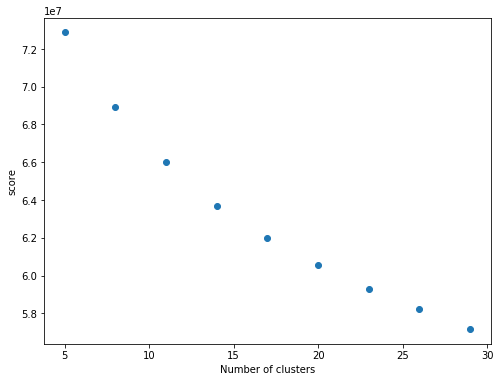

In [25]:
# Investigating the change in within-cluster distance across number of clusters.
plt.figure(figsize = (8,6))
plt.scatter(score_vs_k.keys(), score_vs_k.values())
plt.xlabel('Number of clusters')
plt.ylabel('score')
plt.show()


In [55]:
# Re-fitting the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans= KMeans(14)
model = kmeans.fit(X_pca)
labels = model.predict(X_pca)
score = np.abs(model.score(X_pca))
    
print(labels)
print(labels.size)
print(score)

demo_less['labels'] = labels
demo_less.head()

[12  1 10 ...  1  8  5]
797545
63712716.0980167


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,KBA05_BAUMAX_2.0,KBA05_BAUMAX_3.0,KBA05_BAUMAX_4.0,KBA05_BAUMAX_5.0,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0,labels
0,1.0,2,1,5,2,5,4,5,0,3.0,...,0,0,0,1,1,0,0,0,0,12
1,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,0,0,1,0,0,0,0,1
2,4.0,2,4,2,5,2,1,2,0,2.0,...,0,0,0,0,1,0,0,0,0,10
3,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,0,0,1,0,0,0,5
4,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0,0,0,1,0,0,0,0,2


In [56]:
if (element<=14 for element in demo_less['labels']):
    print('All is good')
else:
    print('Bug!')

All is good


In [57]:
demo_less.to_csv('demo_less_final.csv', sep = ';')

### Discussion 3.1: Apply Clustering to General Population

I carried out clustering with increasing number of clusters and checked the score belonging to the number of clusters. Applying the "elbow method" I found that working with more than 14 clusters, the imrovement in accuracy score is not too relevant, so I chose my final model with 14 clusters. That model will be applied for the customer dataset too.

### Step 3.2: Apply All Steps to the Customer Data

Now that I have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. 

In [13]:
demo_less = pd.read_csv('demo_less1.csv', sep = ';')

In [31]:
# Loading in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep = ';')
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


#### I cleaned the customers dataset on a different day and saved it, so I just load it here.

In [33]:
customers_cleaned = pd.read_csv('customers1.csv', sep = ';')
customers_cleaned.head()

,Unnamed: 0,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,...,KBA05_BAUMAX_1.0,KBA05_BAUMAX_2.0,KBA05_BAUMAX_3.0,KBA05_BAUMAX_4.0,KBA05_BAUMAX_5.0,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0
0,0,4,1,5,1,5,1,2,2,1,...,0,0,0,0,0,1,0,0,0,0
1,2,4,2,5,1,5,1,4,4,1,...,0,0,0,0,0,0,0,1,0,0
2,3,4,1,5,1,5,2,1,2,0,...,1,0,0,0,0,1,0,0,0,0
3,4,3,1,3,1,4,4,5,2,0,...,0,0,0,0,0,0,1,0,0,0
4,5,3,1,5,1,5,1,2,3,1,...,0,0,0,0,0,1,0,0,0,0


In [34]:
customers_cleaned.drop(['Unnamed: 0'], axis = 1, inplace = True)
customers_cleaned.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,KBA05_BAUMAX_1.0,KBA05_BAUMAX_2.0,KBA05_BAUMAX_3.0,KBA05_BAUMAX_4.0,KBA05_BAUMAX_5.0,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0
0,4,1,5,1,5,1,2,2,1,1,...,0,0,0,0,0,1,0,0,0,0
1,4,2,5,1,5,1,4,4,1,2,...,0,0,0,0,0,0,0,1,0,0
2,4,1,5,1,5,2,1,2,0,2,...,1,0,0,0,0,1,0,0,0,0
3,3,1,3,1,4,4,5,2,0,3,...,0,0,0,0,0,0,1,0,0,0
4,3,1,5,1,5,1,2,3,1,3,...,0,0,0,0,0,1,0,0,0,0


In [35]:
# Applying preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
for feature in customers_cleaned.columns:
    customers_cleaned[feature] = customers_cleaned[feature].replace(np.nan, 0)
    


In [37]:
customers_cleaned_scaled = scaler.fit_transform(customers_cleaned)

customers_cleaned_scaled[0:10]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


array([[ 0.66037606, -0.7029562 ,  0.72315575, ..., -0.18794094,
        -0.18888483, -0.27807668],
       [ 0.66037606,  1.42256373,  0.72315575, ...,  5.32082038,
        -0.18888483, -0.27807668],
       [ 0.66037606, -0.7029562 ,  0.72315575, ..., -0.18794094,
        -0.18888483, -0.27807668],
       ...,
       [ 0.66037606,  1.42256373, -2.22355297, ..., -0.18794094,
        -0.18888483,  3.59613034],
       [-0.65020149, -0.7029562 ,  0.72315575, ..., -0.18794094,
        -0.18888483, -0.27807668],
       [ 0.66037606, -0.7029562 ,  0.72315575, ..., -0.18794094,
        -0.18888483, -0.27807668]])

In [38]:
# apply the same pca transformation
X_pca_cust = pca.fit_transform(customers_cleaned_scaled)

In [58]:
labels_cust = model.predict(X_pca_cust)
score = np.abs(model.score(X_pca_cust))

print(labels_cust)
print(labels_cust.size)
print(score)

customers_cleaned['labels'] = labels_cust
customers_cleaned.head()
    

[ 9  6  2 ...  9  6 10]
141690
12778086.459183628


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,KBA05_BAUMAX_2.0,KBA05_BAUMAX_3.0,KBA05_BAUMAX_4.0,KBA05_BAUMAX_5.0,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0,labels
0,4,1,5,1,5,1,2,2,1,1,...,0,0,0,0,1,0,0,0,0,9
1,4,2,5,1,5,1,4,4,1,2,...,0,0,0,0,0,0,1,0,0,6
2,4,1,5,1,5,2,1,2,0,2,...,0,0,0,0,1,0,0,0,0,2
3,3,1,3,1,4,4,5,2,0,3,...,0,0,0,0,0,1,0,0,0,5
4,3,1,5,1,5,1,2,3,1,3,...,0,0,0,0,1,0,0,0,0,5


In [60]:
if (element<=14 for element in customers_cleaned['labels']):
    print('All is good')
else:
    print('Bug!')

All is good


In [61]:
customers_cleaned.to_csv('customers_final.csv', sep = ';')


### Step 3.3: Compare Customer Data to Demographics Data

At this point, I have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, I will compare the two cluster distributions to see where the strongest customer base for the company is.

I will consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then I should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.



In [2]:
# Comparing the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

customers = pd.read_csv('customers_final.csv', sep = ';')
customers.head()

,Unnamed: 0,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,...,KBA05_BAUMAX_2.0,KBA05_BAUMAX_3.0,KBA05_BAUMAX_4.0,KBA05_BAUMAX_5.0,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0,labels
0,0,4,1,5,1,5,1,2,2,1,...,0,0,0,0,1,0,0,0,0,9
1,1,4,2,5,1,5,1,4,4,1,...,0,0,0,0,0,0,1,0,0,6
2,2,4,1,5,1,5,2,1,2,0,...,0,0,0,0,1,0,0,0,0,2
3,3,3,1,3,1,4,4,5,2,0,...,0,0,0,0,0,1,0,0,0,5
4,4,3,1,5,1,5,1,2,3,1,...,0,0,0,0,1,0,0,0,0,5


In [3]:
customers.drop(['Unnamed: 0'], axis = 1, inplace = True)
customers.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,KBA05_BAUMAX_2.0,KBA05_BAUMAX_3.0,KBA05_BAUMAX_4.0,KBA05_BAUMAX_5.0,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0,labels
0,4,1,5,1,5,1,2,2,1,1,...,0,0,0,0,1,0,0,0,0,9
1,4,2,5,1,5,1,4,4,1,2,...,0,0,0,0,0,0,1,0,0,6
2,4,1,5,1,5,2,1,2,0,2,...,0,0,0,0,1,0,0,0,0,2
3,3,1,3,1,4,4,5,2,0,3,...,0,0,0,0,0,1,0,0,0,5
4,3,1,5,1,5,1,2,3,1,3,...,0,0,0,0,1,0,0,0,0,5


In [31]:
distr_cust = customers['labels'].value_counts().rename_axis('label').reset_index(name = 'number of people')
distr_cust = distr_cust.sort_values(by = ['label'])
distr_cust['percentage'] = distr_cust['number of people']/distr_cust['number of people'].sum()
distr_cust

,label,number of people,percentage
11,0,1812,0.012788
0,1,17893,0.126283
6,2,12116,0.085511
9,3,7496,0.052904
4,4,15272,0.107785
7,5,11495,0.081128
3,6,15760,0.111229
8,7,7898,0.055741
5,8,13002,0.091764
2,9,16379,0.115597


In [38]:
demo = pd.read_csv('demo_less_final.csv', sep = ';')
demo.drop(['Unnamed: 0'], axis = 1, inplace = True)
distr_demo = demo['labels'].value_counts().rename_axis('label').reset_index(name = 'number of people')
distr_demo['percentage'] = distr_demo['number of people']/distr_demo['number of people'].sum()
distr_demo = distr_demo.sort_values(by = ['label'])
distr_demo

,label,number of people,percentage
11,0,37466,0.046977
4,1,70049,0.087831
7,2,56570,0.070930
10,3,41365,0.051865
1,4,81017,0.101583
0,5,81243,0.101866
2,6,77842,0.097602
6,7,63977,0.080217
5,8,69847,0.087578
9,9,45781,0.057402


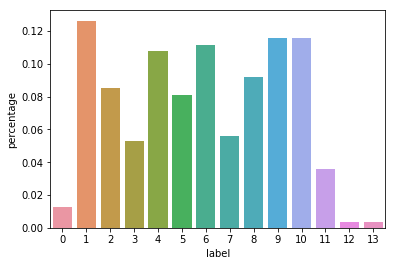

In [39]:
ax = sns.barplot(x = 'label', y = 'percentage', data = distr_cust)

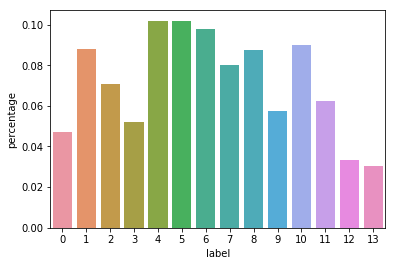

In [40]:
ax = sns.barplot(x = 'label', y = 'percentage', data= distr_demo)

In [42]:
# the data frame to compare the datasets (customer dataset related to the demographic dataset)

compare = pd.DataFrame({'represented':[2, 3,4,6,8, 10], 'underrepresented':[0,5,7,11, 12, 13], 'overrepresented':[1,9,'-','-','-','-']})
compare

,represented,underrepresented,overrepresented
0,2,0,1
1,3,5,9
2,4,7,-
3,6,11,-
4,8,12,-
5,10,13,-


In [2]:
demo = pd.read_csv('demo_less_final.csv', sep = ';')
demo.drop(['Unnamed: 0'], axis = 1, inplace = True)
demo.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,KBA05_BAUMAX_2.0,KBA05_BAUMAX_3.0,KBA05_BAUMAX_4.0,KBA05_BAUMAX_5.0,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0,labels
0,1.0,2,1,5,2,5,4,5,0,3.0,...,0,0,0,1,1,0,0,0,0,12
1,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,0,0,1,0,0,0,0,1
2,4.0,2,4,2,5,2,1,2,0,2.0,...,0,0,0,0,1,0,0,0,0,10
3,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,0,0,1,0,0,0,5
4,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0,0,0,1,0,0,0,0,2


In [3]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

label_1 = []
for i in range(len(demo['labels'])):
    if demo['labels'][i] == 1:
        label_1.append(i)
    
print('The number of people labelled 1: ', len(label_1))
print(label_1)
      


The number of people labelled 1:  70049
[1, 5, 8, 11, 13, 14, 20, 30, 33, 35, 40, 61, 70, 95, 103, 115, 126, 128, 129, 132, 144, 151, 191, 193, 199, 212, 239, 243, 244, 258, 278, 296, 324, 326, 344, 347, 353, 354, 365, 372, 397, 406, 409, 410, 412, 418, 433, 438, 450, 489, 497, 500, 501, 514, 519, 538, 545, 551, 553, 586, 603, 608, 620, 630, 636, 644, 650, 655, 664, 684, 685, 692, 701, 711, 718, 739, 749, 767, 788, 793, 800, 820, 827, 828, 829, 840, 852, 856, 884, 887, 892, 897, 908, 939, 945, 958, 967, 987, 1005, 1038, 1044, 1050, 1060, 1067, 1081, 1086, 1109, 1114, 1117, 1121, 1139, 1190, 1191, 1195, 1203, 1204, 1228, 1236, 1237, 1239, 1243, 1246, 1275, 1303, 1311, 1324, 1334, 1344, 1345, 1351, 1356, 1380, 1393, 1394, 1395, 1397, 1402, 1442, 1445, 1453, 1464, 1476, 1487, 1488, 1490, 1492, 1496, 1500, 1514, 1519, 1522, 1529, 1530, 1551, 1566, 1569, 1575, 1588, 1589, 1591, 1613, 1635, 1640, 1641, 1659, 1684, 1687, 1693, 1702, 1715, 1721, 1723, 1734, 1740, 1744, 1754, 1757, 1779, 1792, 

In [16]:
import collections

LP_STATUS_GROB_1 = []
HH_EINKOMMEN_SCORE = []
PLZ8_ANTG3 = []
PLZ8_ANTG4 = []
ORTSGR_KLS9 = []
EWDICHTE = []
FINANZ_HAUSBAUER = []
KBA05_ANTG4 = []

for i in label_1:
    LP_STATUS_GROB_1.append(demo['LP_STATUS_GROB_1.0'][i])
    HH_EINKOMMEN_SCORE.append(demo['HH_EINKOMMEN_SCORE'][i])
    PLZ8_ANTG3.append(demo['PLZ8_ANTG3'][i])
    PLZ8_ANTG4.append(demo['PLZ8_ANTG4'][i])
    ORTSGR_KLS9.append(demo['ORTSGR_KLS9'][i])
    EWDICHTE.append(demo['EWDICHTE'][i])
    
print(collections.Counter(LP_STATUS_GROB_1))
print(collections.Counter(HH_EINKOMMEN_SCORE))
print(collections.Counter(PLZ8_ANTG3))
print(collections.Counter(PLZ8_ANTG4))
print(collections.Counter(ORTSGR_KLS9))
print(collections.Counter(EWDICHTE))

    
    

Counter({0: 47431, 1: 22618})
Counter({5.0: 24990, 4.0: 17022, 6.0: 14701, 3.0: 7819, 2.0: 3784, 1.0: 1733})
Counter({1.0: 35054, 2.0: 17368, 0.0: 17352, 3.0: 275})
Counter({0.0: 51353, 1.0: 18570, 2.0: 126})
Counter({4.0: 14725, 5.0: 14326, 3.0: 13066, 2.0: 9742, 1.0: 6262, 6.0: 4540, 7.0: 3674, 8.0: 1610, 9.0: 1488, 0.0: 616})
Counter({2.0: 20353, 4.0: 13916, 1.0: 12375, 3.0: 10698, 5.0: 9894, 6.0: 2721, 0.0: 92})


In [ ]:
# LP_STATUS_GROB_1.0: low income earners
# HH_EINKOMMEN_SCO: RE: lower income
# PLZ8_ANTG3.: lower share of 6-10 family home (number of 6-10 family houses in the region)
# PLZ8_ANTG4.: no 10+ family homes (number of 10+ family houses in the region)
# ORTSGR_KLS9 : 10-50k inhabitants (size of community)
# EWDICHTE: 34 -  89 households per km^2 (density of housholds)

# lower income earners in smaller communities where, probably in countryside where the population density is lower and 
# there is less or no big family houses

In [18]:

label_9 = []
for i in range(len(demo['labels'])):
    if demo['labels'][i] == 9:
        label_9.append(i)
    
print('The number of people labelled 9: ', len(label_9))
print(label_9)

The number of people labelled 9:  45781
[25, 31, 34, 44, 46, 77, 90, 96, 105, 140, 155, 158, 181, 186, 202, 218, 226, 231, 246, 295, 297, 321, 338, 351, 391, 393, 394, 449, 476, 483, 531, 537, 548, 592, 611, 634, 665, 687, 697, 706, 712, 714, 741, 780, 781, 785, 786, 790, 792, 798, 835, 864, 904, 907, 912, 961, 989, 991, 1004, 1039, 1073, 1100, 1104, 1107, 1110, 1111, 1123, 1179, 1186, 1187, 1202, 1207, 1208, 1225, 1235, 1261, 1267, 1276, 1362, 1368, 1378, 1381, 1386, 1403, 1407, 1413, 1443, 1458, 1469, 1475, 1483, 1484, 1486, 1554, 1573, 1579, 1632, 1643, 1665, 1667, 1668, 1834, 1845, 1925, 1950, 1957, 1987, 1994, 2038, 2072, 2083, 2090, 2133, 2146, 2158, 2236, 2265, 2298, 2384, 2385, 2409, 2445, 2452, 2556, 2610, 2617, 2623, 2625, 2628, 2629, 2648, 2657, 2674, 2675, 2682, 2707, 2717, 2721, 2741, 2748, 2788, 2805, 2808, 2819, 2825, 2855, 2860, 2861, 2866, 2923, 2948, 2949, 2966, 2978, 2984, 3006, 3061, 3066, 3087, 3101, 3103, 3107, 3137, 3140, 3164, 3199, 3201, 3205, 3222, 3234, 3246,

In [19]:
LP_STATUS_GROB_1 = []
HH_EINKOMMEN_SCORE = []
PLZ8_ANTG3 = []
PLZ8_ANTG4 = []
ORTSGR_KLS9 = []
EWDICHTE = []
FINANZ_HAUSBAUER = []
KBA05_ANTG4 = []

for i in label_9:
    LP_STATUS_GROB_1.append(demo['LP_STATUS_GROB_1.0'][i])
    HH_EINKOMMEN_SCORE.append(demo['HH_EINKOMMEN_SCORE'][i])
    PLZ8_ANTG3.append(demo['PLZ8_ANTG3'][i])
    PLZ8_ANTG4.append(demo['PLZ8_ANTG4'][i])
    ORTSGR_KLS9.append(demo['ORTSGR_KLS9'][i])
    EWDICHTE.append(demo['EWDICHTE'][i])
    
print(collections.Counter(LP_STATUS_GROB_1))
print(collections.Counter(HH_EINKOMMEN_SCORE))
print(collections.Counter(PLZ8_ANTG3))
print(collections.Counter(PLZ8_ANTG4))
print(collections.Counter(ORTSGR_KLS9))
print(collections.Counter(EWDICHTE))

Counter({0: 45177, 1: 604})
Counter({4.0: 11513, 3.0: 9530, 2.0: 9059, 1.0: 8373, 5.0: 6355, 6.0: 951})
Counter({1.0: 21992, 0.0: 13604, 2.0: 9754, 3.0: 431})
Counter({0.0: 34358, 1.0: 11205, 2.0: 218})
Counter({5.0: 9482, 4.0: 9236, 3.0: 7350, 2.0: 6144, 1.0: 3808, 6.0: 3546, 7.0: 3090, 8.0: 1545, 9.0: 1314, 0.0: 266})
Counter({2.0: 12548, 4.0: 8946, 1.0: 7619, 5.0: 7350, 3.0: 6649, 6.0: 2616, 0.0: 53})


In [ ]:
# LP_STATUS_GROB_1:
# HH_EINKOMMEN_SCORE: average income
# PLZ8_ANTG3 : same
# PLZ8_ANTG4: same
# ORTSGR_KLS9: same
# EWDICHTE: same

In [22]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

label_5 = []
for i in range(len(demo['labels'])):
    if demo['labels'][i] == 5:
        label_5.append(i)
    
print('The number of people labelled 5: ', len(label_5))
print(label_5)



The number of people labelled 5:  81243
[3, 6, 48, 65, 73, 81, 91, 99, 100, 101, 110, 113, 139, 142, 146, 149, 168, 174, 175, 188, 197, 204, 237, 250, 261, 271, 289, 322, 330, 341, 359, 361, 362, 377, 385, 386, 411, 414, 425, 428, 439, 461, 466, 478, 494, 507, 511, 516, 529, 532, 534, 536, 540, 543, 547, 565, 583, 601, 609, 639, 641, 652, 663, 678, 683, 688, 729, 765, 799, 803, 807, 830, 832, 845, 849, 851, 854, 860, 876, 880, 899, 916, 918, 926, 935, 942, 949, 953, 955, 956, 965, 969, 970, 985, 990, 992, 994, 1003, 1021, 1028, 1036, 1046, 1048, 1052, 1055, 1062, 1071, 1088, 1122, 1126, 1128, 1136, 1142, 1148, 1151, 1152, 1156, 1209, 1213, 1255, 1257, 1268, 1269, 1278, 1287, 1291, 1297, 1299, 1305, 1309, 1315, 1322, 1346, 1357, 1365, 1367, 1377, 1385, 1389, 1422, 1423, 1430, 1431, 1446, 1447, 1459, 1467, 1525, 1545, 1549, 1553, 1559, 1568, 1581, 1597, 1600, 1603, 1604, 1605, 1625, 1674, 1698, 1701, 1705, 1711, 1739, 1748, 1760, 1765, 1766, 1783, 1793, 1807, 1817, 1820, 1821, 1825, 1830

In [23]:
LP_STATUS_GROB_1 = []
HH_EINKOMMEN_SCORE = []
PLZ8_ANTG3 = []
PLZ8_ANTG4 = []
ORTSGR_KLS9 = []
EWDICHTE = []
FINANZ_HAUSBAUER = []
KBA05_ANTG4 = []

for i in label_5:
    LP_STATUS_GROB_1.append(demo['LP_STATUS_GROB_1.0'][i])
    HH_EINKOMMEN_SCORE.append(demo['HH_EINKOMMEN_SCORE'][i])
    PLZ8_ANTG3.append(demo['PLZ8_ANTG3'][i])
    PLZ8_ANTG4.append(demo['PLZ8_ANTG4'][i])
    ORTSGR_KLS9.append(demo['ORTSGR_KLS9'][i])
    EWDICHTE.append(demo['EWDICHTE'][i])
    
print(collections.Counter(LP_STATUS_GROB_1))
print(collections.Counter(HH_EINKOMMEN_SCORE))
print(collections.Counter(PLZ8_ANTG3))
print(collections.Counter(PLZ8_ANTG4))
print(collections.Counter(ORTSGR_KLS9))
print(collections.Counter(EWDICHTE))

Counter({1: 48887, 0: 32356})
Counter({6.0: 40116, 5.0: 27528, 4.0: 10498, 3.0: 2472, 2.0: 550, 1.0: 79})
Counter({2.0: 38973, 3.0: 30984, 1.0: 9270, 0.0: 2016})
Counter({1.0: 48276, 2.0: 17310, 0.0: 15657})
Counter({7.0: 17046, 5.0: 16003, 8.0: 13467, 9.0: 12867, 6.0: 11012, 4.0: 7845, 3.0: 2159, 2.0: 491, 0.0: 277, 1.0: 76})
Counter({6.0: 34300, 5.0: 23677, 4.0: 12266, 3.0: 4991, 2.0: 4825, 1.0: 1169, 0.0: 15})


In [ ]:
# LP_STATUS_GROB_1
# HH_EINKOMMEN_SCORE: very low income
# PLZ8_ANTG3: average share of 3-5 family homes
# PLZ8_ANTG4: lower share of 10+ family homes
# ORTSGR_KLS9:100,001 to 300,000 inhabitants
# EWDICHTE: more than 999 households per km^2

# same with 7

In [26]:
label_11 = []
for i in range(len(demo['labels'])):
    if demo['labels'][i] == 11:
        label_11.append(i)
    
print('The number of people labelled 11: ', len(label_11))
print(label_11)

The number of people labelled 11:  49654
[57, 59, 106, 109, 159, 163, 170, 187, 206, 216, 222, 268, 293, 333, 339, 342, 352, 363, 375, 379, 388, 405, 416, 442, 443, 451, 452, 467, 468, 473, 520, 526, 530, 555, 556, 557, 560, 570, 573, 576, 595, 628, 638, 640, 662, 674, 716, 731, 752, 753, 754, 760, 763, 791, 817, 836, 838, 842, 844, 847, 861, 894, 903, 914, 927, 946, 954, 973, 974, 993, 1007, 1010, 1024, 1027, 1051, 1074, 1075, 1099, 1102, 1144, 1145, 1146, 1176, 1210, 1218, 1254, 1258, 1265, 1271, 1283, 1320, 1338, 1340, 1358, 1366, 1400, 1437, 1441, 1450, 1468, 1494, 1495, 1510, 1557, 1562, 1571, 1586, 1602, 1608, 1620, 1623, 1646, 1699, 1776, 1782, 1796, 1799, 1822, 1823, 1872, 1875, 1878, 1887, 1896, 1903, 1922, 1947, 1972, 1980, 2004, 2052, 2053, 2064, 2102, 2145, 2154, 2164, 2168, 2196, 2215, 2223, 2234, 2270, 2272, 2273, 2293, 2314, 2342, 2346, 2355, 2364, 2366, 2367, 2372, 2374, 2379, 2423, 2439, 2471, 2506, 2534, 2573, 2574, 2614, 2618, 2632, 2644, 2690, 2701, 2708, 2715, 2725

In [27]:
LP_STATUS_GROB_1 = []
HH_EINKOMMEN_SCORE = []
PLZ8_ANTG3 = []
PLZ8_ANTG4 = []
ORTSGR_KLS9 = []
EWDICHTE = []
FINANZ_HAUSBAUER = []
KBA05_ANTG4 = []

for i in label_11:
    LP_STATUS_GROB_1.append(demo['LP_STATUS_GROB_1.0'][i])
    HH_EINKOMMEN_SCORE.append(demo['HH_EINKOMMEN_SCORE'][i])
    PLZ8_ANTG3.append(demo['PLZ8_ANTG3'][i])
    PLZ8_ANTG4.append(demo['PLZ8_ANTG4'][i])
    ORTSGR_KLS9.append(demo['ORTSGR_KLS9'][i])
    EWDICHTE.append(demo['EWDICHTE'][i])
    
print(collections.Counter(LP_STATUS_GROB_1))
print(collections.Counter(HH_EINKOMMEN_SCORE))
print(collections.Counter(PLZ8_ANTG3))
print(collections.Counter(PLZ8_ANTG4))
print(collections.Counter(ORTSGR_KLS9))
print(collections.Counter(EWDICHTE))

Counter({1: 42447, 0: 7207})
Counter({6.0: 32813, 5.0: 12742, 4.0: 3392, 3.0: 617, 2.0: 81, 1.0: 9})
Counter({3.0: 26976, 2.0: 16704, 1.0: 3472, 0.0: 2502})
Counter({2.0: 32184, 1.0: 15536, 0.0: 1934})
Counter({9.0: 19400, 7.0: 9438, 8.0: 7657, 5.0: 5781, 6.0: 4379, 4.0: 2255, 3.0: 545, 0.0: 102, 2.0: 84, 1.0: 13})
Counter({6.0: 31649, 5.0: 10639, 4.0: 4461, 3.0: 1464, 2.0: 1200, 1.0: 237, 0.0: 4})


In [ ]:
# LP_STATUS_GROB_1: same
# HH_EINKOMMEN_SCORE: same
# PLZ8_ANTG3: high share of 6-10 family homes
# PLZ8_ANTG4: high share of 10+ family homes
# ORTSGR_KLS9: > 700,000  inhabitants
# EWDICHTE: more than 999 households per km^2

### Discussion 3.3: Compare Customer Data to Demographics Data

According to my analysis, the main target of the mail-order company are people that live in towns with lower population, in smaller houses (e.g. not big family houses) and have an average or lower income. People who live in larger towns or cities, especially in districts with high population density (assumingly poorer people) and whose income is lower than the average, are less popular with the company. I used the first component in PCA and investigated the features with larger weight. I collected information of people in clusters that are over/underrepresented in the customer dataset compared to the demographic dataset. Investigating more clusters, I came to very similar conclusions, so I can say that my first statements are supported by my investigations.